<h1>CS4618: Artificial Intelligence I</h1>
<h1>Regression Case Study</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix
from seaborn import scatterplot, heatmap

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_error

from joblib import dump

In [44]:
import os
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "." 

<h1>Introductory Remarks</h1>
<ul>
    <li>In this lecture, we're going to rattle through the steps of a slightly larger case study.</li>
    <li>This will help bring out the importance of some steps we have not mentioned yet, including:
        <ul>
            <li>Dataset acquisition;</li>
            <li>Dataset exploration; and</li>
            <li>Dataset preprocessing.</li>
        </ul>
    </li>
    <li>If this were a module about data analytics, then each topic would fill several lectures. 
        <figure>
            <img src="images/data_science.png" />
            <figcaption>
                (Image adapted from one by Andy Sherpenberg)
            </figcaption>
        </figure>
    </li>
    <li>
        Since this is
        a module about AI, our treatment will be much more cursory.
    </li>
 </ul>

<h1>Identify the Problem</h1>
<ul>
    <li>What are the business objectives?</li>
    <li>How do we expect to benefit by building and using an AI system for making predictions?
        How will it contribute to the business objectives?
    </li>
</ul>

<h1>Select Performance Measures</h1>
<ul>
    <li>Select a performance measure:
        <ul>
            <li>E.g. for regression, we might select MAE.
        </ul>
    </li>
    <li>But we might also want a 'reference point' to know whether we have succeeded:
        <ul>
            <li>E.g. maybe we have succeeded if our MAE is 10% lower than the current system's MAE.</li>
            <li>E.g. maybe we must not only be better than the current system but statistically significantly
                better (according to some test of statistical significance).
            </li>
            <li>E.g. maybe we have succeeded if MAE is no greater than some threshold.</li>
        </ul>
    </li>
    <li>Sometimes there is more than one performance measure:
        <ul>
            <li>E.g. maybe in regression we want to separate the errors by measuring overestimates 
                separately from underestimates.
            </li>
            <li>E.g. maybe we want to measure time or memory used for training.</li>
            <li>E.g. maybe we want to measure time or memory used for inference (when making a prediction).</li>
            <li>E.g. maybe we want an incremental learning algorithm that can easily accommodate new training
                examples when they arise.
            </li>
            <li>E.g. maybe we care about learning an interpretable model or being able to explain the system's
                predictions.
            </li>
            <li>And so on.</li>
        </ul>
    </li>
</ul>           

<h1>Dataset Acquisition</h1>
<ul>
    <li>Where will the dataset come from? 
        <ul>
            <li>Existing databases and files? By scanning paper documents? By scraping web sites?
                &hellip;</li>
        </ul>
    </li>
    <li>What quantities of data are available? How much do you need?</li>
    <li>What format is it in? What will you need to do to convert it?
        <ul>
            <li>E.g. you may need to de-normalize relational databases or flatten other data structures such as trees
        and graphs in order to produce the tabular (matrix) format that most of the scikit-learn learning algorithms expect.</li>
            <li>E.g. you may need to handle different character encodings.</li>
        </ul>
    </li>
    <li>Are there legal or ethical issues: copyright, authorization, privacy, bias? E.g. will you need to
        anonymize? Will you need to de-bias?
    </li>
    <li>If you need a labeled dataset, are the labels available? Are they reliable? How will you
        obtain them if not? (Get an expert? Get several experts? Use crowdsourcing? Use a data labeling company?)
    </li>
</ul>

<h1>Data Cleaning</h1>
<ul>
    <li>Take a quick look at the data: compute some summary statistics, look at a few examples.</li>
    <li>Identify any problems: data that is simply invalid.</li>
    <li>Clean the data accordingly:
        <ul>
            <li>E.g. datasets may contain rows that violate your normal data validation criteria:
                <ul>
                    <li>perhaps a feature value is required but there are rows where it is missing;</li>
                    <li>perhaps there is a maximum value for a feature and there are rows where this maximum is exceeded;</li>
                    <li>perhaps a non-numeric feature has a finite set of allowed values but some rows contain illegal values for this feature.</li>
                </ul>
                You must either fix these rows (if that is possible) or delete them. 
            </li>
            <li>E.g. if we are doing supervised learning, we need target values: they cannot be missing and
                they need to be sensible.
            </li>
            <li>E.g. we may need to identify and handle duplicated examples.
        </ul>
    </li>
    <li>Note that this is one of several steps where it would be useful to be able to discuss with
        a domain expert.
    </li>
</ul>

<h2>Data cleaning for the Cork Property Prices Dataset</h2>
<ul>
    <li>Let's illustrate data cleaning for a different (less clean) version of the Cork Property Prices Dataset.</li>
</ul>

In [45]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(os.path.join(base_dir, "../datasets/dataset_corkB.csv"))

# Shuffle the dataset
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [46]:
# The dimensions
df.shape

(711, 9)

In [47]:
# The columns, their datatypes and whether there are nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   flarea    583 non-null    float64
 1   type      711 non-null    object 
 2   bdrms     707 non-null    float64
 3   bthrms    711 non-null    int64  
 4   floors    711 non-null    int64  
 5   devment   706 non-null    object 
 6   ber       560 non-null    object 
 7   location  711 non-null    object 
 8   price     690 non-null    float64
dtypes: float64(3), int64(2), object(4)
memory usage: 50.1+ KB


In [48]:
# Summary statistics
df.describe(include="all")

,flarea,type,bdrms,bthrms,floors,devment,ber,location,price
count,583.000000,711,707.000000,711.000000,711.000000,706,560,711,690.000000
unique,NaN,4,NaN,NaN,NaN,2,14,47,NaN
top,NaN,detached,NaN,NaN,NaN,SecondHand,C1,Cork City,NaN
freq,NaN,221,NaN,NaN,NaN,700,64,130,NaN
mean,139.016226,NaN,3.287129,2.039381,1.853727,NaN,NaN,NaN,333.627536
std,157.192735,NaN,1.146934,1.146272,0.457777,NaN,NaN,NaN,191.264933
min,8.100000,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,50.000000
25%,80.540000,NaN,3.000000,1.000000,2.000000,NaN,NaN,NaN,225.000000
50%,108.000000,NaN,3.000000,2.000000,2.000000,NaN,NaN,NaN,280.000000
75%,142.450000,NaN,4.000000,3.000000,2.000000,NaN,NaN,NaN,380.000000


In [49]:
# Maybe have a look at a few rows
df.head()

,flarea,type,bdrms,bthrms,floors,devment,ber,location,price
0,NaN,terraced,3.0,1,2,SecondHand,NaN,Wilton,225.0
1,134.78,detached,4.0,1,1,SecondHand,NaN,Curraheen,385.0
2,94.70,semi-detached,3.0,2,2,SecondHand,B3,Douglas,299.0
3,NaN,semi-detached,3.0,2,2,SecondHand,NaN,Wilton,300.0
4,NaN,apartment,2.0,2,1,SecondHand,B2,Blackrock,245.0


In [50]:
features = ["flarea", "bdrms", "bthrms", "floors", "type", "devment", "ber", "location"]
numeric_features = ["flarea", "bdrms", "bthrms", "floors"]
nominal_features = ["type", "devment", "ber", "location"]

In [51]:
# The values, in the case of nominal-valued features
for feature in nominal_features:
    print(feature, df[feature].unique())

type ['terraced' 'detached' 'semi-detached' 'apartment']
devment ['SecondHand' nan 'New']
ber [nan 'B3' 'B2' 'D2' 'C1' 'C2' 'C3' 'G' 'E2' 'E1' 'D1' 'F' 'A3' 'B1' 'A2']
location ['Wilton' 'Curraheen' 'Douglas' 'Blackrock' 'Ballinlough' 'Tivoli'
 'Mayfield' 'Bishopstown' 'Glanmire' 'Cork City' 'Turners Cross'
 'Passage West' 'Model Farm Road' 'Rochestown' 'Gurranabraher' 'Farranree'
 'Blarney' 'Ballinvoultig' 'Fairhill' 'Ballyphehane' 'Lehenaghmore'
 'Ballyvolane' 'Waterfall' 'Kilcully' 'Ovens' 'Little Island'
 'Ballintemple' "Sunday's Well" 'Blackpool' 'St. Lukes' 'Silversprings'
 'Donnybrook' 'Mahon' 'Montenotte' 'Frankfield' 'Carrigrohane'
 'Western Road' 'Dillons Cross' 'Banduff' 'The Lough' 'Killeens'
 'Shanakiel' 'Glasheen' 'Togher' 'Inniscarra' 'Victoria Cross'
 'Dublin Pike']


<ul>
    <li>What problems do you see?</li>
    <li>Let's assume that, according to our normal data validation criteria, it is invalid to supply
        no value for $\mathit{devment}$ but it is OK to supply no value for $\mathit{ber}$. So we will delete
        rows that have NaN for their $\mathit{devment}$.
    </li>
    <li>Let's assume similarly that values for $\mathit{flarea}$ cannot be missing and must be greater
        than or equal to 40 and less than 750. So we will delete rows that violate these conditions too.
    </li>
    <li>Let's assume we also want to delete rows where $\mathit{bdrms}$ is NaN. 
    </li>
    <li>We must delete the rows where $\mathit{price}$ is NaN because we are doing supervised learning!
        But I fear that some of these prices are wrong too. A scatter plot helps show why I think this.
    </li>
</ul>

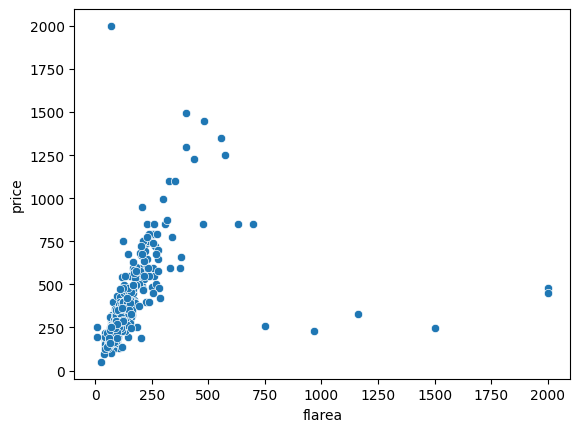

In [52]:
plot = scatterplot(x="flarea", y="price", data=df)

<ul>
    <li>So let's look at the row(s) that have the very high price tag:</li>
</ul>

In [53]:
df[df["price"] >= 2000]

,flarea,type,bdrms,bthrms,floors,devment,ber,location,price
163,70.0,semi-detached,3.0,1,2,SecondHand,E1,Blackpool,2000.0


<ul>
    <li>Undoubtedly a typo! So we will delete this row too.</li>
</ul>

In [54]:
# Delete examples where flarea, devment or price are NaN
df.dropna(subset=["flarea", "bdrms", "devment", "price"], inplace=True)

# Delete examples whose floor areas are too small or too big
df = (df[(df["flarea"] >= 40) & (df["flarea"] < 750)]).copy()

# Delete examples whose prices are too high
df = (df[df["price"] < 2000]).copy()

# Reset the index
df.reset_index(drop=True, inplace=True)

# Check the invalid data was filtered out
df.shape

(552, 9)

<h1>Create a Test Set</h1>
<ul>
    <li>Split off a test set.</li>
    <li>Don't look at it: everything we do until our final error estimation will be done on the rest of
        the dataset.
    </li>
</ul>

In [55]:
# Split off the test set: 20% of the dataset.
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

<h1>Dataset Exploration</h1>
<ul>
    <li>Time spent just exploring the data is always worthwhile &mdash; especially if you have 
        access to a domain expert while you are doing so.
    </li>
    <li><b>Visualization</b> is a great help at this stage.
        <ul>
            <li>Given a labeled dataset, we often want to see how target values are distributed 
                with respect to values of one or more of the features.
            </li>
            <li>Given a labeled or unlabeled dataset, we might want to see how values of one feature are 
                correlated with values of one or more other features.
            </li>
        </ul>
        A limitation is that visualizations are confined to two (or maybe three) columns of the dataset.
    </li>
</ul>

In [56]:
# It can be good to do this on a copy of the dataset (excluding the test set, of course)
copy_df = dev_df.copy()

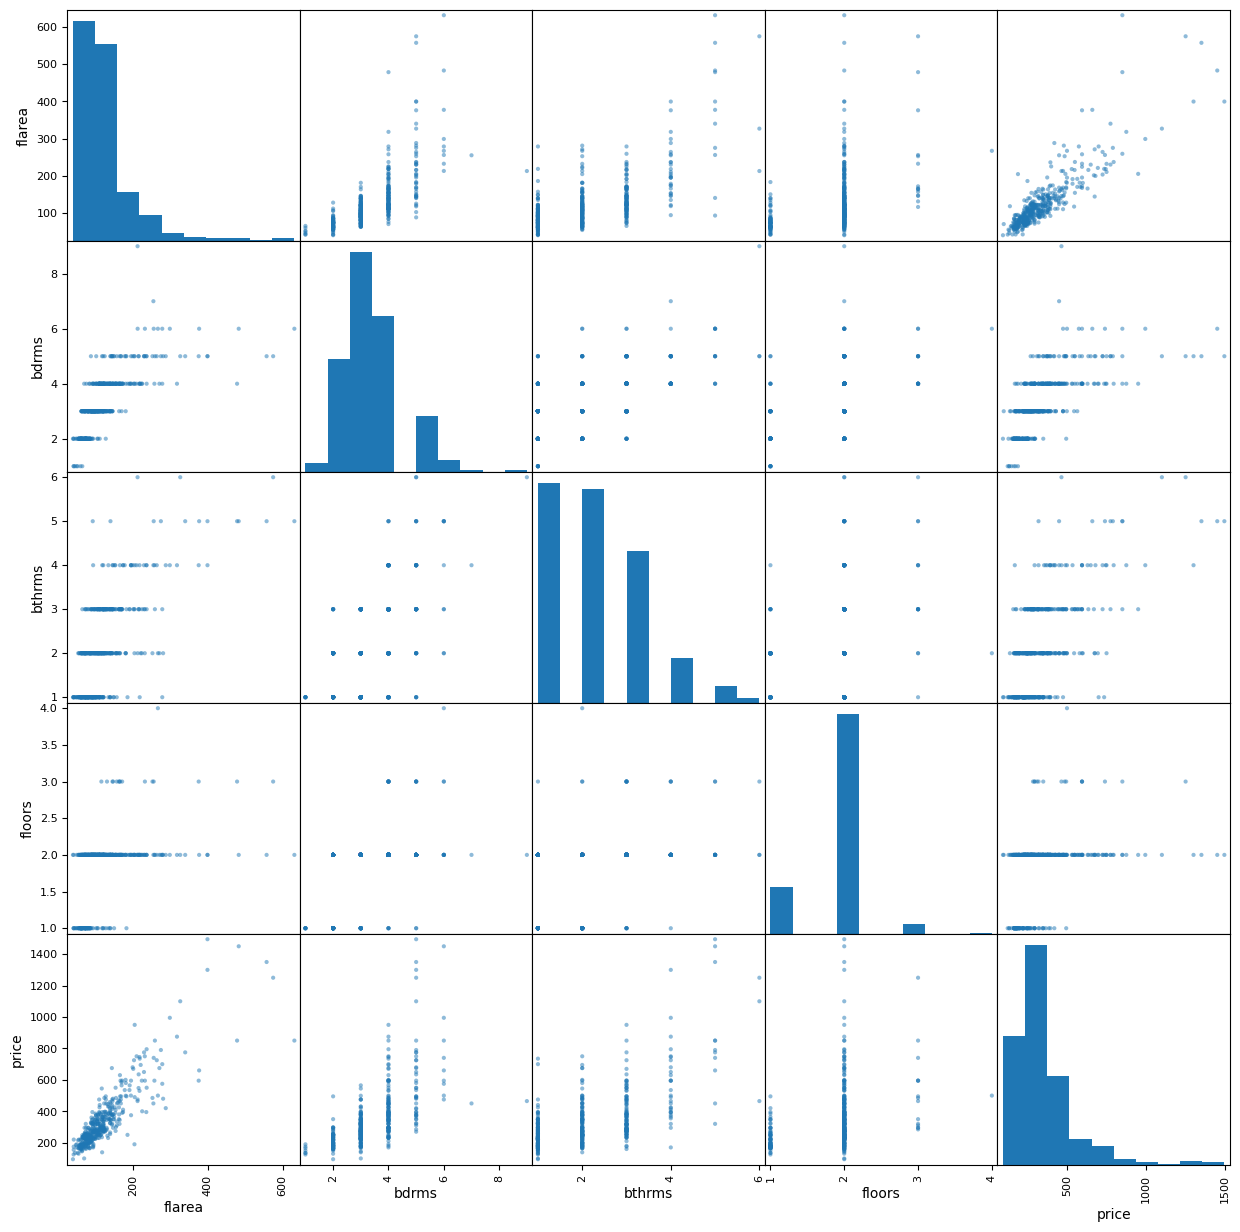

In [57]:
m = scatter_matrix(copy_df, figsize=(15, 15))

<ul>
    <li>For any that look interesting, we can draw a bigger scatter plot.
    </li>
</ul>

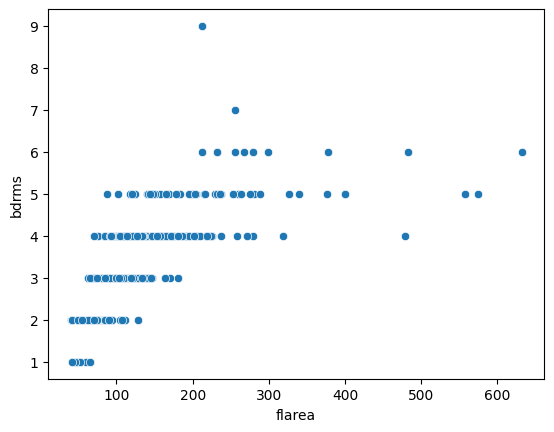

In [58]:
plot = scatterplot(x="flarea", y="bdrms", data=copy_df)

<ul>
    <li>We can compute correlations between numeric-valued columns.</li>
    <li>Most common is Pearson correlation, which measures linear correlation. Its value lies between +1 and −1. 
        A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total 
        negative linear correlation.
    </li>
</ul>

In [59]:
copy_df[["flarea", "bdrms", "bthrms", "floors", "price"]].corr()

,flarea,bdrms,bthrms,floors,price
flarea,1.000000,0.698069,0.658241,0.377075,0.875564
bdrms,0.698069,1.000000,0.567874,0.477100,0.640647
bthrms,0.658241,0.567874,1.000000,0.261110,0.618934
floors,0.377075,0.477100,0.261110,1.000000,0.316447
price,0.875564,0.640647,0.618934,0.316447,1.000000


<p>
    If you prefer, you can show this as a heatmap instead, or as well:
</p>

<Axes: >

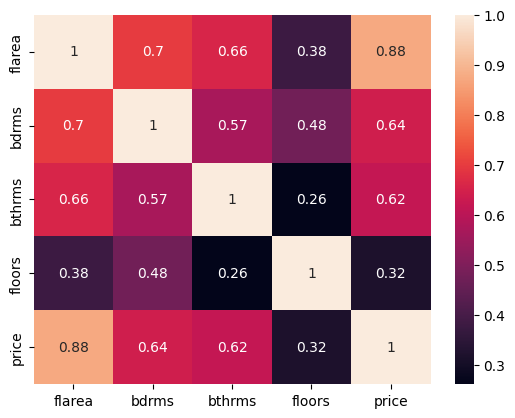

In [60]:
heatmap(copy_df[["flarea", "bdrms", "bthrms", "floors", "price"]].corr(), annot=True)

<ul>
    <li>We see that $\mathit{flarea}$ is strongly predictive of $\mathit{price}$.</li>
    <li>We see that $\mathit{flarea}$, $\mathit{bdrms}$ and $\mathit{bthrms}$ are quite strongly correlated
        with each other.
    </li>
    <li>We see that $\mathit{bdrms}$ and $\mathit{floors}$ are fairly strongly correlated.</li>
    <li>We can add other features, ones that are computed from the existing features &mdash; later, we call this
        <b>feature engineering</b>. 
        <ul>
            <li>In general, these new features might be products or ratios of existing features.</li>
            <li>Or they might result from applying functions to existing features, e.g. squaring, square rooting,
                taking the log, &hellip;
            </li>
            <li>If you're going to be learning a linear model then it will not be useful to the linear model to add or subtract features or to multiply or divide by a scalar,
                since this just gives new features that are linearly correlated with existing features.
            </li>
        </ul>
        We can then produce visualizations and compute correlations to
        see whether these new features are predictive or not.
    </li>
</ul>

In [61]:
copy_df["room_size"] = copy_df["flarea"] / (copy_df["bdrms"] + copy_df["bthrms"])

In [62]:
copy_df[["flarea", "bdrms", "bthrms", "floors", "price"]].corr()

,flarea,bdrms,bthrms,floors,price
flarea,1.000000,0.698069,0.658241,0.377075,0.875564
bdrms,0.698069,1.000000,0.567874,0.477100,0.640647
bthrms,0.658241,0.567874,1.000000,0.261110,0.618934
floors,0.377075,0.477100,0.261110,1.000000,0.316447
price,0.875564,0.640647,0.618934,0.316447,1.000000


<ul>
    <li>E.g. this new feature is quite predictive of price, but highly correlated with floor area.</li>
</ul>

<h1>Dataset Preparation</h1>
<ul>
    <li>We need to prepare the dataset so that it is suitable for machine learning algorithms.</li>
    <li>An incomplete lists of activities follows.</li>
    <li>Missing values:
        <ul>
            <li>Most learning algorithms cannot handle missing values.</li>
            <li>We may have removed most of them during data cleaning.</li>
            <li>If any remain, we need a method to <b>impute</b> a value.
                <ul>
                    <li>For numeric-valued features, we can replace missing values by the mean, for example.
                        (In scikit-learn, use the <code>SimpleImputer</code> with <code>strategy="mean"</code>,
                        which is the default.)
                    </li>
                    <li>For nominal-valued features, we can replace by the mode.
                        (<code>strategy="most_frequent"</code>)
                    </li>
                    <li>There are other possibilities, e.g.: replace by some constant; binarize the feature
                        (0 if the value was missing, 1 if not); predict the value from the other features.
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Scaling numeric-valued features:
        <ul>
            <li>Some algorithms (e.g. kNN) perform less well if features have different ranges. <!-- ; others
                (e.g. linear regression done using the normal equation) work equally well whether the
                data is scaled or not. -->
            <li>We've mentioned two ways to scale: min-max scaling and standardization. There are others.</li>
        </ul>
    </li>
    <li>Feature engineering:
        <ul>
            <li>In this module we use the phrase <b>feature engineering</b> for the following:
                augmenting the dataset with features that are computed from the other features.
            </li>
            <li>These may have been identified during dataset exploration above.</li>
        </ul>
    </li>
    <li>Feature selection:
        <ul>
            <li>There are methods for removing features that have low predictive power.
        </ul>
    </li>
    <li>Dimensionality reduction:
        <ul>
            <li>An example of this is Principal Component Analysis. Ignoring the details, it transforms
                the features into new features that are not linearly correlated with one another
                and enables us to discard the new features that contribute least.
            </li>
        </ul>
    </li>
    <li>Handling nominal-valued features:
        <ul>
            <li>Non-numeric features deserve separate explanation below.
        </ul>
    </li>
</ul>

<h2>Handling Nominal-Valued Features</h2>
<ul>
    <li>Most AI algorithms work only with numeric-valued features.</li>
    <li>So, we will look at how to convert nominal-valued features to numeric-valued ones.</li>
</ul>

<h3>Binary-valued features</h3>
<ul>
    <li>The simplest case, obviously, is a binary-valued feature, such as $\mathit{devment}$.</li>
    <li>We encode one value as 0 and the other as 1, e.g. "SecondHand" is 0 and "New" is 1.</li>
</ul>

<h3>Unordered nominal values</h3>
<ul>
    <li>Suppose there are more than two values, e.g. Apartment, Detached, Semi-detached or Terraced.</li>
    <li>The obvious thing to do is to assign integers to each nominal value, e.g. 0 = Apartment, 1 = Detached, 
        2 = Semi-detached and 3 = Terraced.
    </li>
    <li>But often this is not the best encoding.
        <ul>
            <li>Algorithms may assume that the values themselves are meaningful, when they're actually arbitrary.
                <ul>
                    <li>E.g. an algorithm might assume that Apartments (0) are more similar to Detached houses (1)
                        than they are to Terraced houses (3).
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Instead, we use <b>one-hot encoding</b>.</li>
</ul>

<h3>One-Hot Encoding</h3>
<ul>
    <li>If the original nominal-valued feature has $p$ values, then we use $p$ binary-valued features: 
        <ul>
            <li>In each example, exactly one of them is set to 1 and the rest are zero.</li>
        </ul>
    </li>
    <li>For example, there are four types of dwelling, so we have four binary-valued features:
        <ul>
            <li>the first is set to 1 if and only if the type of dwelling is Apartment;</li>
            <li>the second is set to 1 if and only if the house is Detached;</li>
            <li>and so on.</li>
        </ul>
        So a detached house will be represented by $\rv{0, 1, 0, 0}$.
    </li>
    <li>
        In practice, it is not uncommon to be given a dataset where a nominal-valued feature has already been 
        encoded numerically, one integer per value. You might be fooled into thinking that the feature is
        numeric-valued and overlook the need to use one-hot encoding on it. Watch out for this!
    </li>
    <li>One-hot encoding turns each $p$-valued non-numeric feature into $p$ binary-valued features. Thus, you
        can end up with a lot of features. Maybe you need to do some dimensionality reduction afterwards.
    </li>
</ul>

<h2>Data preprocessing in scikit-learn</h2>
<ul>
    <li>Clearly, we want to automate all these data preparation activities.</li>
    <li>In scikit-learn, it is best to bring all of them together using a <code>ColumnTransformer</code>,
        <code>Pipelines</code> and, sometimes, <code>FeatureUnions</code>.
    </li>
</ul>

In [63]:
# Create the preprocessor
preprocessor = ColumnTransformer([
        ("scaler", StandardScaler(), 
                numeric_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), 
                          ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), 
                nominal_features)],
        remainder="drop")

<ul>
    <li>Let's say we want to do some feature engineering. We could add extra features in the way we did
        when we were exploring the dataset, e.g.
        <pre>
        df["room_size"] = df["flarea"] / (df["bdrms"] + df["bthrms"])
        </pre>
        The problem is that this code is separate from our <code>ColumnTransformer</code>.
        And this leads to complications: for example, if we save our model, then this part of it won't be saved.
        If we can make it part of the <code>ColumnTransformer</code>, then it will be saved along
        with everything else.
    </li>
    <li>The solution is to write our own transformer.</li>
</ul>

In [64]:
class InsertRoomSize(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["room_size"] = X["flarea"] / (X["bdrms"] + X["bthrms"])
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
            # X.drop(["flarea", "bthrms", "bdrms"], axis=1)
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

<ul>
    <li>Now our preprocessor might look like this:</li>
</ul>

In [65]:
preprocessor = ColumnTransformer([
        ("num", Pipeline([("room_size", InsertRoomSize()),
                          ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                          ("scaler", StandardScaler())]), 
                numeric_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), 
                          ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), 
                nominal_features)],
        remainder="drop")

<h1>Prepare for Model Selection</h1>
<ul>
    <li>We have already split off our test set.</li>
    <li>But now we decide how to do model selection (see previous lecture):
        <ul>
            <li>Should we just split the remaining data into a training set and validation set?</li>
            <li>Or should we use $k$-fold cross-validation?</li>
        </ul>
        As discussed, it depends on how much data you have.
        <ul>
            <li>Since our dataset is quite small, we'll use $k$-fold cross-validation.</li>
        </ul>
    </li>
    <li>We must also decide which models we will experiment with.
        <ul>
            <li>We'll use linear regression and kNN.</li>
        </ul>
    </li>
    <li>And for each model, we must set up a grid of hyperparameter values.
        <ul>
            <li>For kNN, we need to try some different values for $k$.</li>
            <li>But we did something clever earlier when creating our own feature engineering transformer.
                We included an argument called <code>insert</code>. If this is True, then
                we add the extra feature; if it is False, we do not. Hence, this is a hyperparameter.
                We can try both values to see whether adding the feature helps or not.
            </li>
        </ul>
    </li>
</ul>

In [66]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]

# Target values, converted to a 1D numpy array
dev_y = dev_df["price"].values
test_y = test_df["price"].values

In [67]:
# Create a pipeline that combines the preprocessor with kNN
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor())])

# Create a dictionary of hyperparameters for kNN
knn_param_grid = {"predictor__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  "preprocessor__num__room_size__insert": [True, False]}

# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(knn, knn_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
knn_gs.fit(dev_X, dev_y)

# Let's see how well we did
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 10, 'preprocessor__num__room_size__insert': True},
 np.float64(-58.62432828282829))

In [68]:
# Create a pipeline that combines the preprocessor with ridge regression
ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", Ridge())])

# Create a dictionary of hyperparameters for ridge regression
ridge_param_grid = {"preprocessor__num__room_size__insert": [True, False],
                    "predictor__alpha": [0, 45.0, 50.0, 55.0]}

# Create the grid search object which will find the best hyperparameter values based on validation error
ridge_gs = GridSearchCV(ridge, ridge_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
ridge_gs.fit(dev_X, dev_y)

# Let's see how well we did
ridge_gs.best_params_, ridge_gs.best_score_

({'predictor__alpha': 45.0, 'preprocessor__num__room_size__insert': False},
 np.float64(-57.32078658536407))

<ul>
    <li>In fact, we can even use a grid search to select between different transformers of the same kind.
    </li>
    <li>The example below, we select between a <code>StandardScaler</code>, a <code>MinMaxScaler</code>
        and a <code>RobustScaler</code>.
    </li>
</ul>

In [69]:
preprocessor = ColumnTransformer([
        ("num", Pipeline([("room_size", InsertRoomSize()),
                          ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                          ("scaler", None)]), 
                numeric_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), 
                          ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), 
                nominal_features)],
        remainder="drop")

In [70]:
# Create a pipeline that combines the preprocessor with kNN
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor())])

# Create a dictionary of hyperparameters for kNN
knn_param_grid = {"predictor__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  "preprocessor__num__room_size__insert": [True, False],
                  "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()]}

# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(knn, knn_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
knn_gs.fit(dev_X, dev_y)

# Let's see how well we did
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 8,
  'preprocessor__num__room_size__insert': False,
  'preprocessor__num__scaler': RobustScaler()},
 np.float64(-57.041414141414144))

In [77]:
# Create a pipeline that combines the preprocessor with ridge regression
ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", Ridge())])

# Create a dictionary of hyperparameters for rideg regression
ridge_param_grid = {"preprocessor__num__room_size__insert": [True, False],
                     "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
                     "predictor__alpha": [0, 45.0, 50.0, 55.0]}

# Create the grid search object which will find the best hyperparameter values based on validation error
ridge_gs = GridSearchCV(ridge, ridge_param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

# Run grid search by calling fit. It will also re-train on train+validation using the best parameters.
ridge_gs.fit(dev_X, dev_y)

# Let's see how well we did
ridge_gs.best_params_, ridge_gs.best_score_

({'predictor__alpha': 45.0,
  'preprocessor__num__room_size__insert': False,
  'preprocessor__num__scaler': RobustScaler()},
 np.float64(-56.4182319509037))

<h1>Tweak and Fine Tune</h1>
<ul>
    <li>Now tweak and tune your model(s).
        <ul>
            <li>E.g. go back and change the grid of hyperparameter values.</li>
            <li>E.g. go back and add or remove transformers.</li>
            <li>E.g. go back and try regressors other than linear regression and kNN.</li>
            <li>E.g. you could even go back to the Dataset Acquisition step: maybe try to collect
                more features, for example. 
            </li>
        </ul>
    </li>
    <li>You don't have to do this wholly at random. You can be guided in part by knowing whether you
        are underfitting or overfitting.
        <ul>
            <li>E.g. if you are underfitting, then collecting new features or doing feature engineering may help.
            </li>
            <li>But if you are overfitting then selecting among your features may be better.
            </li>
        </ul>
        See previous two lectures.
    </li>
</ul>

In [72]:
scores = cross_validate(knn_gs, dev_X, dev_y, cv=10, 
                        scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  49.643819864714075
Validation error:  58.0679604978355


In [73]:
scores = cross_validate(ridge_gs, dev_X, dev_y, cv=10, 
                        scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  53.797322038187794
Validation error:  56.4182319509037


<ul>
    <li>You can tweak and tune as much as you like!
        Keep doing this until you find a good model.
    </li>
    <li>Of course, if you're not careful, you'll overdo it and produce a model that overfits the training
        data.
    </li>
    <li>The main thing you shouldn't do, of course, is look at the test set until you have finished all
        this tweaking and tuning.
    </li>
</ul>

<h1>Evaluate on the Test Set</h1>
<ul>
    <li>Once you've done, then, using the best model(s) we found, we can do error estimation on the test set.</li>
</ul>

In [74]:
# Now we test on the test set
mean_absolute_error(test_y, ridge_gs.predict(test_X))

66.68491272190326

<h1>Deploy</h1>
<ul>
    <li>Make a decision: is this predictor good enough for real use?
        <ul>
            <li>You may be comparing one model against other models (e.g. linear regression against kNN regression) or against baselines (e.g. predicting the mean) or against current practice (e.g. your current manual or non-AI system).
            </li>
            <li>To make this comparison more robust, you might compute confidence intervals (see, e.g., 
                <a href="https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html">this tutorial</a>) or carry out a test for statistical significance. Unfortunately, we don't have time to study these in this module.
            </li>
        </ul>
    </li>
    <li>If this predictor is good enough to be deployed, then re-train on the entire dataset, save the model and use it in your web app.</li>
</ul>

In [75]:
ridge_gs.fit(df[features], df["price"].values)
dump(ridge, os.path.join(base_dir, 'models/my_model.pkl')) # For this to work, create a folder called models!

['./models/my_model.pkl']

<ul>
    <li>Of course, even then your work is not finished:
        <ul>
            <li>You need to monitor peformance.</li>
            <li>You may need to re-train it when fresh data becomes available.</li>
            <li>And so on.</li>
        </ul>
    </li>
</ul>

<h1>Appendix</h1>
<h2>One-hot encoding</h2>
<ul>
    <li>As discussed above, when we one-hot encode, we replace a nominal-valued feature that has $p$ values with $p$ binary-valued features.</li>
    <li>But, if you think about it, you'll realise you only need $p - 1$ features, not $p$. Why?</li>
    <li>Using just $p - 1$ may have an advantage, especially if your model uses matrix inversion (e.g. see linear regression using the Normal Equation): it reduces colinearities between the features.</li>
    <li>If you want to try this, then include <code>drop="first"</code> as a parameter to the <code>OneHotEncoder</code> class.</li>
    <li>But, be warned, using just $p - 1$ features has a problem: it conflicts with <code>handle_unknown="ignore"</code>. In what way?</li>
</ul>